In [1]:
# Read json file
import json
import numpy as np
import requests
import os
import pandas as pd
from sklearn import preprocessing
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import warnings

# Dataframe

In [2]:
playlists_df = pd.read_csv('playlists.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

print(headers)

['index', 'title', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


In [3]:
mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [4]:
playlists = json.load(open('playlists.json', 'r'))
tracks = json.load(open('track_features.json', 'r'))

# Clustering

### K-means

In [5]:
def get_cluster_tracks(playlists_df, cluster_preds, num_clusters, verbose=False):
    global playlists, tracks
    
    playlists_clustered = playlists_df.get(['index', 'title']).copy()
    playlists_clustered['cluster'] = cluster_preds

    cluster_tracks = [{} for _ in range(num_clusters)]
    for cluster in range(num_clusters):
        for i in playlists_clustered[playlists_clustered['cluster'] == cluster]['index']:
            for track in playlists[i][1]:
                if track['track_uri'] not in cluster_tracks[cluster]:
                    cluster_tracks[cluster][track['track_uri']] = track
        cluster_tracks[cluster] = np.array(list(cluster_tracks[cluster].values()))

        if verbose:
            print('Cluster {}: {} tracks'.format(cluster, len(cluster_tracks[cluster])))

    return cluster_tracks

def cluster_custom_score(playlists_df, cluster_preds, num_clusters):
    global tracks
    
    cluster_tracks = get_cluster_tracks(playlists_df, cluster_preds, num_clusters)

    lengths = np.array([len(tracks) for tracks in cluster_tracks])

    return np.sum(lengths) / len(tracks), \
        np.max(lengths) / len(tracks), \
        np.std(lengths) / np.mean(lengths)

In [6]:
duplication_factors = []
reduction_factors = []
variation_coefficients = []
davies_bouldins = []
silhouette_scores = []

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    silhouette = silhouette_score(playlists_df[headers[2:]], labels)
    
    duplication_factors.append(duplication_factor)
    reduction_factors.append(reduction_factor)
    variation_coefficients.append(variation_coefficient)
    davies_bouldins.append(davies_bouldin)
    silhouette_scores.append(silhouette)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}, Silhouette = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin, silhouette))

K = 2, CTDF = 1.00631655630708, CTRF = 0.6398141457694175, CCV = 0.2715961826512505, DB = 1.5499797781262485, Silhouette = 0.3013532165063027
K = 3, CTDF = 1.0358826595278425, CTRF = 0.5752300967768683, CCV = 0.5960663149840372, DB = 1.5380131493438556, Silhouette = 0.22969651290031523
K = 4, CTDF = 1.1348686938084127, CTRF = 0.41787884531100083, CCV = 0.45436957472741324, DB = 1.7068494614845537, Silhouette = 0.1627119938212019
K = 5, CTDF = 1.2019195460845051, CTRF = 0.3206636974212577, CCV = 0.3725935510960383, DB = 1.7157063598849223, Silhouette = 0.15042338652467604
K = 6, CTDF = 1.2527747835254261, CTRF = 0.2872715319647955, CCV = 0.3904729734966785, DB = 1.7661064928903503, Silhouette = 0.13028908168655684
K = 7, CTDF = 1.3087235403513344, CTRF = 0.2420221271958399, CCV = 0.32230320349437264, DB = 1.7459275061880697, Silhouette = 0.125517296857785
K = 8, CTDF = 1.318226507622511, CTRF = 0.2441513367527037, CCV = 0.4176398490375946, DB = 1.6580746811491074, Silhouette = 0.1352073

Text(0.5, 1.0, 'CTDF vs. Number of Clusters')

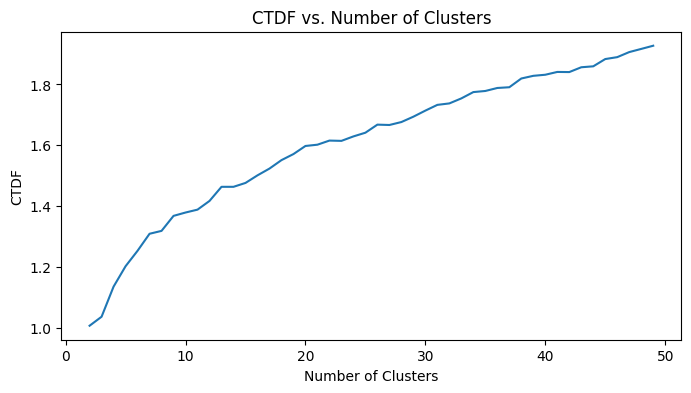

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 50), duplication_factors, label='CTDF') # Cluster Track Duplication Factor
plt.xlabel('Number of Clusters')
plt.ylabel('CTDF')
plt.title('CTDF vs. Number of Clusters')

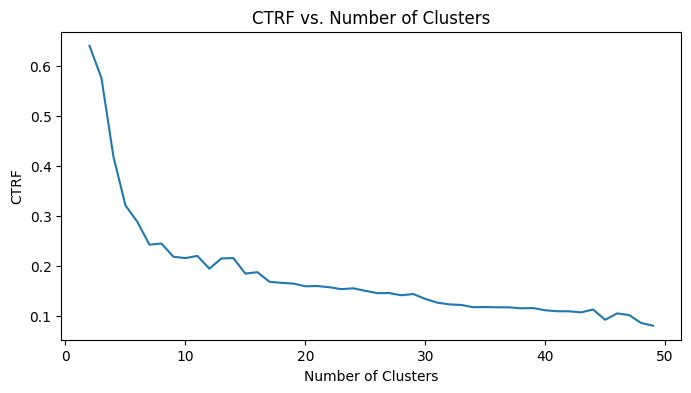

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 50), reduction_factors, label='CTRF') # Cluster Track Reduction Factor
plt.xlabel('Number of Clusters')
plt.ylabel('CTRF')
plt.title('CTRF vs. Number of Clusters')
plt.show()

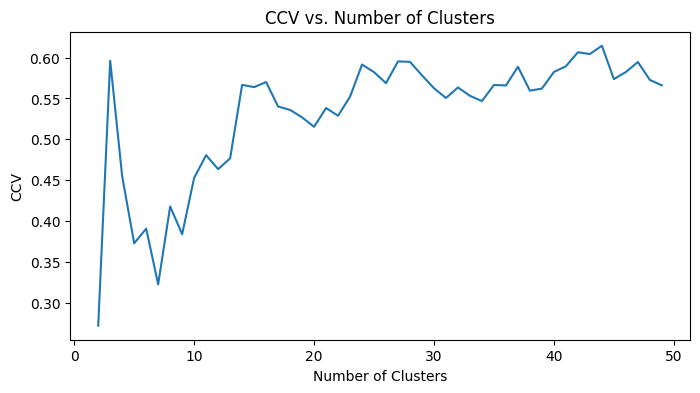

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 50), variation_coefficients, label='CCV') # Cluster Coefficient of Variation
plt.xlabel('Number of Clusters')
plt.ylabel('CCV')
plt.title('CCV vs. Number of Clusters')
plt.show()

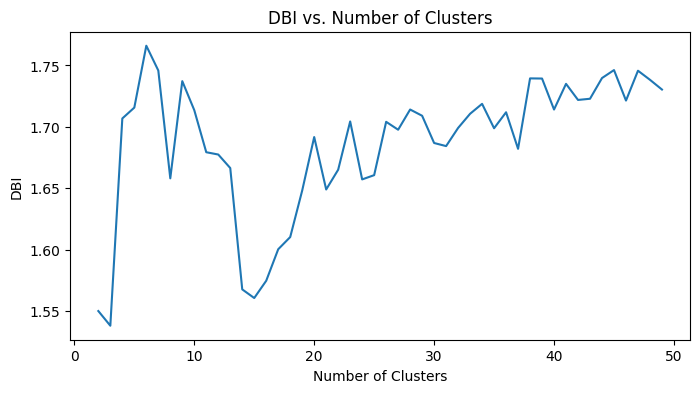

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 50), davies_bouldins, label='DBI') # Davies-Bouldin Index
plt.xlabel('Number of Clusters')
plt.ylabel('DBI')
plt.title('DBI vs. Number of Clusters')
plt.show()

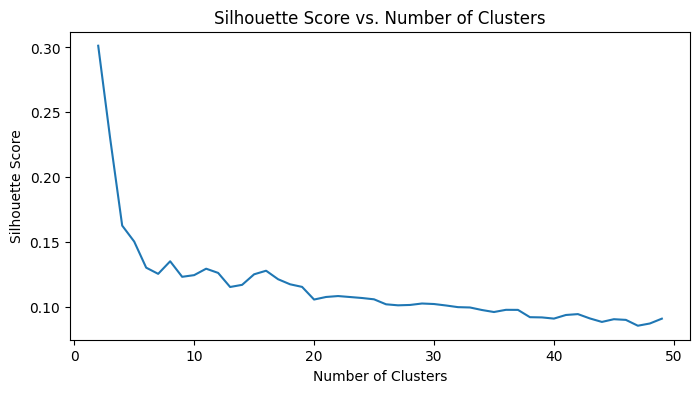

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 50), silhouette_scores, label='Silhouette') # Silhouette Score
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [12]:
NUM_CLUSTERS = 15
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto').fit(playlists_df[headers[2:]])

In [13]:
# Group playlists by cluster
playlists_df['cluster'] = kmeans.labels_
playlists_clustered = playlists_df.get(['index', 'title', 'cluster'])

In [14]:
# Count most common titles
def count_words(titles):
    words = []
    for title in titles:
        title = str(title).strip().lower()
        words += title.split(" ")
    return Counter(words)


for i in range(NUM_CLUSTERS):
    print(count_words(
        playlists_clustered[playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('chill', 181), ('summer', 80), ('good', 63), ('jams', 57), ('music', 56), ('2017', 54), ('r&b', 54), ('vibes', 52), ('2016', 51), ('new', 47)]
[('christmas', 198), ('disney', 98), ('chill', 64), ('songs', 41), ('music', 40), ('the', 40), ('oldies', 36), ('feels', 28), ('sleep', 27), ('musicals', 24)]
[('chill', 146), ('songs', 85), ('love', 70), ('the', 61), ('music', 59), ('worship', 54), ('feels', 53), ('good', 47), ('sad', 43), ('new', 42)]
[('jazz', 33), ('chill', 20), ('music', 19), ('sleep', 12), ('instrumental', 11), ('la', 10), ('study', 9), ('piano', 8), ('the', 7), ('christmas', 7)]
[('chill', 32), ('house', 20), ('music', 12), ('playlist', 12), ('edm', 12), ('dubstep', 11), ('electro', 11), ('good', 10), ('summer', 10), ('2016', 10)]
[('party', 115), ('summer', 79), ('throwback', 78), ('dance', 75), ('old', 73), ('music', 72), ('workout', 60), ('jams', 55), ('songs', 51), ('playlist', 51)]
[('rap', 285), ('lit', 112), ('party', 98), ('hop', 93), ('hip', 89), ('workout', 79

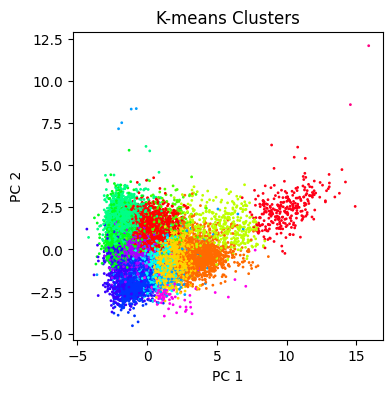

In [22]:
pca = PCA()
pca.fit(playlists_df[headers[2:]])
x = pca.transform(playlists_df[headers[2:]])[:, 0]
y = pca.transform(playlists_df[headers[2:]])[:, 1]

# Plot clusters
plt.figure(figsize=(4, 4))
plt.scatter(x, y, c=kmeans.labels_, s=1, cmap='hsv')
plt.title("K-means Clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [28]:
cluster_tracks = get_cluster_tracks(playlists_df, kmeans.labels_, NUM_CLUSTERS, verbose=True)

Cluster 0: 51425 tracks
Cluster 1: 36186 tracks
Cluster 2: 62151 tracks
Cluster 3: 17130 tracks
Cluster 4: 26915 tracks
Cluster 5: 47843 tracks
Cluster 6: 39851 tracks
Cluster 7: 44596 tracks
Cluster 8: 15036 tracks
Cluster 9: 50171 tracks
Cluster 10: 49577 tracks
Cluster 11: 42071 tracks
Cluster 12: 3632 tracks
Cluster 13: 11 tracks
Cluster 14: 11790 tracks


### DBSCAN

In [17]:
duplication_factors = []
reduction_factors = []
variation_coefficients = []
davies_bouldins = []

for e in range(14, 20):
    e /= 10
    for min_samples in range(2, 10):
        db = DBSCAN(eps=e, min_samples=min_samples).fit(playlists_df[headers[2:]])
        labels = db.labels_ + 1 # now 0 is noise

        clusters = len(set(labels))
        noisy = len([l for l in labels if l == 0])

        duplication_factor, reduction_factor, variation_coefficient = \
            cluster_custom_score(playlists_df, labels, clusters)

        davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
        
        duplication_factors.append(duplication_factor)
        reduction_factors.append(reduction_factor)
        variation_coefficients.append(variation_coefficient)
        davies_bouldins.append(davies_bouldin)

        print('eps = {}, min_samples = {}, clusters = {}, noisy = {}\n\tCTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
            e, min_samples, clusters, noisy, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

eps = 1.4, min_samples = 2, clusters = 179, noisy = 3967
	CTDF = 1.0263678468627475, CTRF = 0.6908470641191172, CCV = 9.64842195956341, DB = 1.3863050508226618
eps = 1.4, min_samples = 3, clusters = 45, noisy = 4235
	CTDF = 1.0120408429182313, CTRF = 0.6908470641191172, CCV = 4.880297143084219, DB = 1.4651892276552476
eps = 1.4, min_samples = 4, clusters = 17, noisy = 4467
	CTDF = 1.0098790585280915, CTRF = 0.6846667298421009, CCV = 2.905113593849672, DB = 1.624836755843809
eps = 1.4, min_samples = 5, clusters = 5, noisy = 4657
	CTDF = 1.0099501308916028, CTRF = 0.6753503275251419, CCV = 1.3255707021577525, DB = 1.9907065846483623
eps = 1.4, min_samples = 6, clusters = 7, noisy = 4805
	CTDF = 1.0160830835929449, CTRF = 0.6697770696864525, CCV = 1.6747891390108922, DB = 1.888852046158512
eps = 1.4, min_samples = 7, clusters = 6, noisy = 4936
	CTDF = 1.0173001978180785, CTRF = 0.6647013183923431, CCV = 1.499299835052016, DB = 2.0939403888578414
eps = 1.4, min_samples = 8, clusters = 6, n

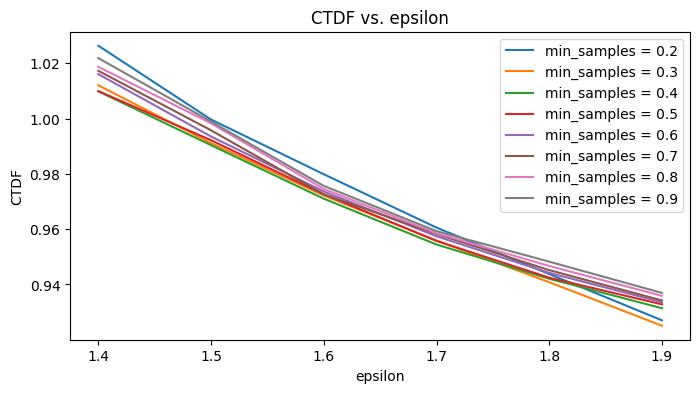

In [18]:
plt.figure(figsize=(8, 4))
for i in range(2, 10):
    plt.plot(np.array(range(14, 20)) / 10, duplication_factors[i-2::8], label='min_samples = {}'.format(i))
plt.xlabel('epsilon')
plt.ylabel('CTDF')
plt.title('CTDF vs. epsilon')
plt.legend()
plt.show()

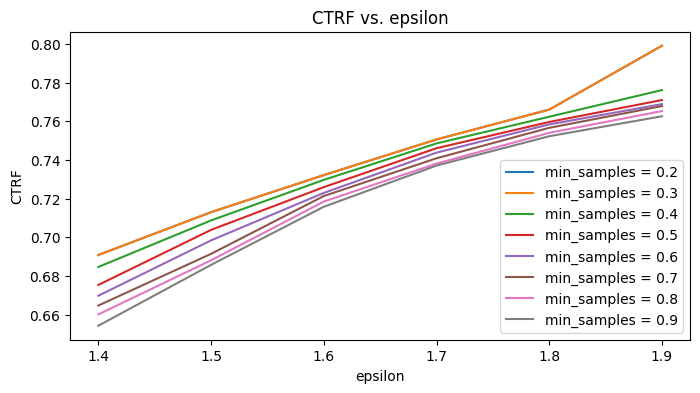

In [19]:
plt.figure(figsize=(8, 4))
for i in range(2, 10):
    plt.plot(np.array(range(14, 20)) / 10, reduction_factors[i-2::8], label='min_samples = {}'.format(i))
plt.xlabel('epsilon')
plt.ylabel('CTRF')
plt.title('CTRF vs. epsilon')
plt.legend()
plt.show()

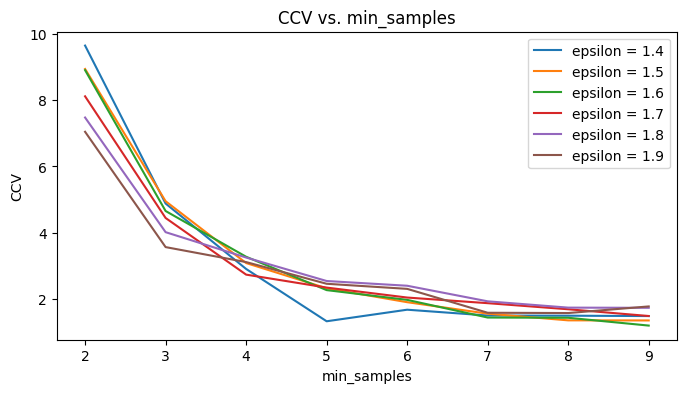

In [20]:
plt.figure(figsize=(8, 4))
for i in range(14, 20):
    plt.plot(range(2, 10), variation_coefficients[(i-14)*8:(i-13)*8], label='epsilon = {}'.format(i/10))
plt.xlabel('min_samples')
plt.ylabel('CCV')
plt.title('CCV vs. min_samples')
plt.legend()
plt.show()

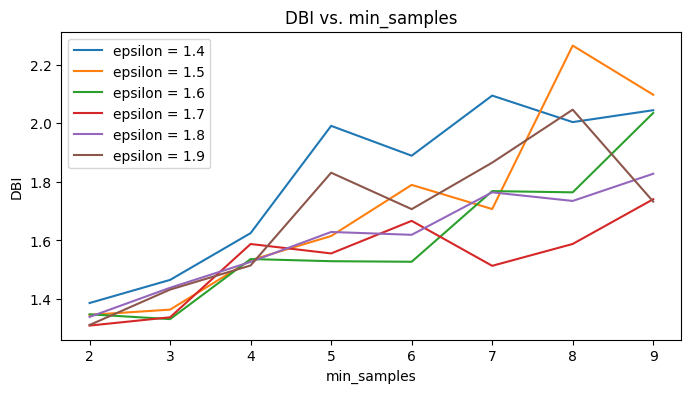

In [21]:
plt.figure(figsize=(8, 4))
for i in range(14, 20):
    plt.plot(range(2, 10), davies_bouldins[(i-14)*8:(i-13)*8], label='epsilon = {}'.format(i/10))
plt.xlabel('min_samples')
plt.ylabel('DBI')
plt.title('DBI vs. min_samples')
plt.legend()
plt.show()

In [17]:
eps = 1.6
min_samples = 3

db = DBSCAN(eps=eps, min_samples=min_samples).fit(playlists_df[headers[2:]])
labels = db.labels_ + 1 # now 0 is noise

In [18]:
playlists_clustered = playlists_df.get(['index', 'title']).copy()
playlists_clustered['cluster'] = labels

clusters = len(set(labels))
cluster_tracks = [set() for _ in range(clusters)]
for cluster in range(clusters):
    for i in playlists_clustered[playlists_clustered['cluster'] == cluster]['index']:
        for track in playlists[i][1]:
            cluster_tracks[cluster].add(track['track_uri'])

lengths = np.array([len(tracks) for tracks in cluster_tracks])

In [19]:
for i in range(clusters):
    print(count_words(
        playlists_clustered[playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('music', 75), ('chill', 66), ('songs', 55), ('classical', 44), ('new', 40), ('the', 40), ('christmas', 40), ('good', 38), ('sleep', 37), ('jazz', 36)]
[('country', 869), ('chill', 600), ('music', 520), ('summer', 475), ('songs', 414), ('rock', 401), ('good', 372), ('party', 366), ('playlist', 346), ('jams', 336)]
[('jazz', 3)]
[('gospel', 2), ('church', 1)]
[('classical', 2), ('productivity', 1)]
[('piano', 5), ('guys', 5), ('the', 3)]
[('study', 7), ('instrumental', 5), ('music', 4), ('movie', 3), ('of', 3), ('time', 2), ('scores', 2), ('harry', 2), ('potter', 2), ('lord', 2)]
[('garage', 1), ('house', 1), ('music', 1), ('disco', 1), ('fever', 1)]
[('gospel', 9), ('praise', 2), ('songs', 1), ('jesus', 1), ('music', 1), ('and', 1), ('worship', 1)]
[('norteñas', 2), ('nortenas', 1)]
[('ariel', 2), ('camacho', 2), ('corridos', 1)]
[('pitch', 3), ('perfect', 3), ('soundtrack', 1)]
[('classical', 7), ('study', 2), ('focus', 1), ('sesh', 1), ('minimal', 1), ('the', 1), ('50', 1), ('greate

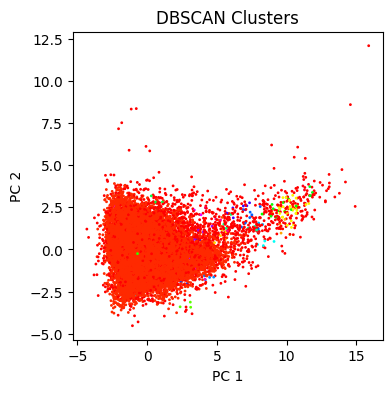

In [21]:
pca = PCA()
pca.fit(playlists_df[headers[2:]])
x = pca.transform(playlists_df[headers[2:]])[:, 0]
y = pca.transform(playlists_df[headers[2:]])[:, 1]

# Plot clusters
plt.figure(figsize=(4, 4))
plt.scatter(x, y, c=labels, s=1, cmap='hsv')
plt.title("DBSCAN Clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()